## Dataset
https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis

## References
https://aclanthology.org/C14-1008.pdf
https://www.bioinf.jku.at/publications/older/2604.pdf



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [12]:
shuffle = False
import pandas as pd
from sklearn.model_selection import train_test_split


dataset = pd.read_csv('/content/drive/MyDrive/datasets/movie.csv', sep=",")
X = dataset["text"]
y = dataset["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=shuffle)

X_train, y_train

(0       I grew up (b. 1965) watching and loving the Th...
 1       When I put this movie in my DVD player, and sa...
 2       Why do people who do not know what a particula...
 3       Even though I have great interest in Biblical ...
 4       Im a die hard Dads Army fan and nothing will e...
                               ...                        
 7995    *May contain spoilers*<br /><br />I bent over ...
 7996    Be very afraid of anyone who likes this film. ...
 7997    Can they possibly get any worse than this? Pro...
 7998    I give it a 2, because of the beautiful Medite...
 7999    I'm not a fan of Adam Sandler. In fact, I don'...
 Name: text, Length: 8000, dtype: object, 0       0
 1       0
 2       0
 3       0
 4       1
        ..
 7995    0
 7996    0
 7997    0
 7998    0
 7999    1
 Name: label, Length: 8000, dtype: int64)

## Two Layer Bidirectional - GRU

In [14]:
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping
from keras.layers import Embedding, TextVectorization, Dense, LSTM, Input, Bidirectional, GRU
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

vectorize_layer = TextVectorization(
  max_tokens=50000,
  standardize="lower_and_strip_punctuation",
  ngrams = 2
)
vectorize_layer.adapt(X_train)

def create_model():
  model = Sequential()

  # Vectorization
  model.add(Input(shape=(1,), dtype=tf.string))
  model.add(vectorize_layer)

  # Embedding
  model.add(Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=64))

  model.add(Bidirectional(GRU(128, return_sequences=True)))
  model.add(Bidirectional(GRU(64)))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])
  return model
  

model = KerasClassifier(build_fn=create_model, verbose=0)

batch_size = [10, 40, 80]
epochs = [20, 30, 50]
param_grid = {"batch_size": batch_size, "epochs": epochs}
# TODO add stratified
early = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=10)
result = grid.fit(X_train, y_train, validation_split=0.1, callbacks=[early])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START batch_size=10, epochs=20....................................
[CV 1/3; 1/9] END .....batch_size=10, epochs=20;, score=0.656 total time= 5.7min
[CV 2/3; 1/9] START batch_size=10, epochs=20....................................


KeyboardInterrupt: ignored

In [ ]:
print("Best params", result.best_params_)
print("Best score", result.best_score_)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

for score in [accuracy_score, recall_score, precision_score, f1_score]:
    print(score(result.predict(X_test), y_test))


## Approach 1 - RRN

In [ ]:
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping
from keras.layers import Embedding, TextVectorization, Dense, LSTM, Input

vectorize_layer = TextVectorization(max_tokens=50000)
vectorize_layer.adapt(X_train)

history_Adam = History()

model = Sequential()

# Vectorization
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

# Embedding
model.add(Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=32))

model.add(LSTM(32, activation='softsign'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.summary()


Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_57 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_42 (Embedding)    (None, None, 32)          1451232   
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dense_57 (Dense)            (None, 16)                528       
                                                                 
 dense_58 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,460,097
Trainable params: 1,460,097
Non-trainable params: 0
___________________________________________

In [ ]:
model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

# early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[history_Adam])

Epoch 1/20
125/125 [==============================] - 67s 532ms/step - loss: 0.6929 - accuracy: 0.5155 - val_loss: 0.6938 - val_accuracy: 0.4988
Epoch 2/20
125/125 [==============================] - 64s 514ms/step - loss: 0.6929 - accuracy: 0.5155 - val_loss: 0.6940 - val_accuracy: 0.4988
Epoch 3/20
125/125 [==============================] - 68s 544ms/step - loss: 0.6927 - accuracy: 0.5238 - val_loss: 0.6935 - val_accuracy: 0.5020
Epoch 4/20
125/125 [==============================] - 70s 565ms/step - loss: 0.6921 - accuracy: 0.5278 - val_loss: 0.6933 - val_accuracy: 0.5025
Epoch 5/20
125/125 [==============================] - 69s 554ms/step - loss: 0.7162 - accuracy: 0.5175 - val_loss: 0.6949 - val_accuracy: 0.4988
Epoch 6/20
125/125 [==============================] - 63s 508ms/step - loss: 0.6914 - accuracy: 0.5225 - val_loss: 0.6942 - val_accuracy: 0.5009
Epoch 7/20
125/125 [==============================] - 69s 553ms/step - loss: 0.6897 - accuracy: 0.5297 - val_loss: 0.6933 - val_ac

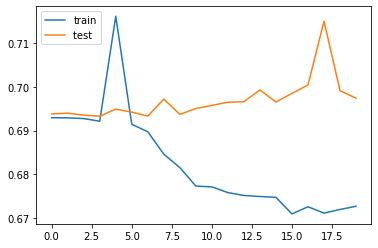

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_Adam.history['loss'], label = "train")
plt.plot(history_Adam.history['val_loss'], label = "test ")



plt.legend()
plt.show()

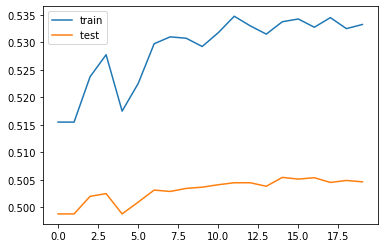

In [ ]:
plt.plot(history_Adam.history['accuracy'], label = "train")
plt.plot(history_Adam.history['val_accuracy'], label = "test ")

plt.legend()
plt.show()


## Approach 2 - Bidirectional


In [ ]:
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping
from keras.layers import Embedding, TextVectorization, Dense, LSTM, Input

vectorize_layer = TextVectorization(max_tokens=50000)
vectorize_layer.adapt(X_train)

history_Adam = History()

model = Sequential()

# Vectorization
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

# Embedding
model.add(Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=64))

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.summary()


Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_58 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_43 (Embedding)    (None, None, 64)          2902464   
                                                                 
 dense_59 (Dense)            (None, None, 128)         8320      
                                                                 
 dense_60 (Dense)            (None, None, 64)          8256      
                                                                 
 dense_61 (Dense)            (None, None, 16)          1040      
                                                                 
 dense_62 (Dense)            (None, None, 1)           17        
                                                     

In [ ]:
model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

# early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[history_Adam])

Epoch 1/20
125/125 [==============================] - 22s 175ms/step - loss: 0.6927 - accuracy: 0.5153 - val_loss: 0.6920 - val_accuracy: 0.5129
Epoch 2/20
125/125 [==============================] - 21s 168ms/step - loss: 0.6897 - accuracy: 0.5252 - val_loss: 0.6907 - val_accuracy: 0.5138
Epoch 3/20
125/125 [==============================] - 21s 169ms/step - loss: 0.6860 - accuracy: 0.5357 - val_loss: 0.6924 - val_accuracy: 0.5149
Epoch 4/20
125/125 [==============================] - 22s 177ms/step - loss: 0.6830 - accuracy: 0.5377 - val_loss: 0.6939 - val_accuracy: 0.5147
Epoch 5/20
125/125 [==============================] - 24s 196ms/step - loss: 0.6814 - accuracy: 0.5378 - val_loss: 0.6943 - val_accuracy: 0.5141
Epoch 6/20
125/125 [==============================] - 24s 196ms/step - loss: 0.6795 - accuracy: 0.5387 - val_loss: 0.6967 - val_accuracy: 0.5143
Epoch 7/20
125/125 [==============================] - 23s 188ms/step - loss: 0.6792 - accuracy: 0.5387 - val_loss: 0.6976 - val_ac

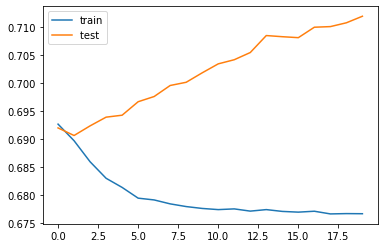

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_Adam.history['loss'], label = "train")
plt.plot(history_Adam.history['val_loss'], label = "test ")



plt.legend()
plt.show()

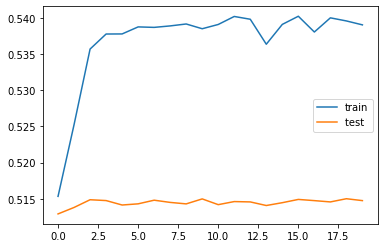

In [ ]:
plt.plot(history_Adam.history['accuracy'], label = "train")
plt.plot(history_Adam.history['val_accuracy'], label = "test ")

plt.legend()
plt.show()


## Approach 3 - GRU

In [ ]:
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping
from keras.layers import Embedding, TextVectorization, Dense, LSTM, Input, Bidirectional

vectorize_layer = TextVectorization(max_tokens=50000)
vectorize_layer.adapt(X_train)

history_Adam = History()

model = Sequential()

# Vectorization
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

# Embedding
model.add(Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=64))


model.add(Bidirectional(tf.keras.layers.GRU(32)))
model.add(Dense(24, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.summary()


Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_59 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_44 (Embedding)    (None, None, 64)          2902464   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               18816     
 l)                                                              
                                                                 
 dense_63 (Dense)            (None, 24)                1560      
                                                                 
 dense_64 (Dense)            (None, 1)                 25        
                                                                 
Total params: 2,922,865
Trainable params: 2,922,865
N

In [ ]:
model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

# early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[history_Adam])

Epoch 1/20
125/125 [==============================] - 97s 755ms/step - loss: 0.6880 - accuracy: 0.5472 - val_loss: 0.6569 - val_accuracy: 0.6255
Epoch 2/20
125/125 [==============================] - 102s 821ms/step - loss: 0.4633 - accuracy: 0.7945 - val_loss: 0.5537 - val_accuracy: 0.7167
Epoch 3/20
125/125 [==============================] - 102s 820ms/step - loss: 0.1556 - accuracy: 0.9457 - val_loss: 0.6116 - val_accuracy: 0.7722
Epoch 4/20
125/125 [==============================] - 100s 801ms/step - loss: 0.0340 - accuracy: 0.9910 - val_loss: 0.7462 - val_accuracy: 0.7715
Epoch 5/20
125/125 [==============================] - 103s 829ms/step - loss: 0.0084 - accuracy: 0.9985 - val_loss: 0.9285 - val_accuracy: 0.7814
Epoch 6/20
125/125 [==============================] - 95s 760ms/step - loss: 0.0084 - accuracy: 0.9975 - val_loss: 1.0466 - val_accuracy: 0.7831
Epoch 7/20
125/125 [==============================] - 95s 761ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 1.1557 - va

In [ ]:
model.evaluate(X_test,y_test)

1125/1125 [==============================] - 63s 56ms/step - loss: 1.5798 - accuracy: 0.7926


[1.5797935724258423, 0.792638897895813]

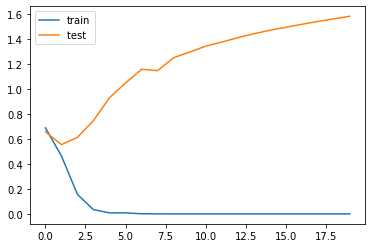

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_Adam.history['loss'], label = "train")
plt.plot(history_Adam.history['val_loss'], label = "test ")



plt.legend()
plt.show()

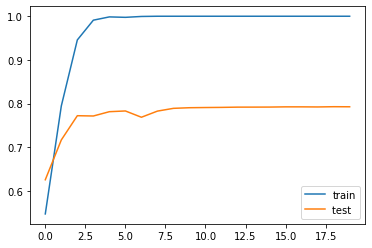

In [ ]:
plt.plot(history_Adam.history['accuracy'], label = "train")
plt.plot(history_Adam.history['val_accuracy'], label = "test ")

plt.legend()
plt.show()


## Approach 4 - TwoLayer - GRU
## https://www.dialog-21.ru/media/3380/arkhipenkoetal.pdf

In [19]:
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping
from keras.layers import Embedding, TextVectorization, Dense, LSTM, Input, Bidirectional, GRU

vectorize_layer = TextVectorization(max_tokens=50000)
vectorize_layer.adapt(X_train)

history_Adam = History()

model = Sequential()

# Vectorization
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

# Embedding
model.add(Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=64))


model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Bidirectional(GRU(64)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_12 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_12 (Embedding)    (None, None, 64)          3200000   
                                                                 
 bidirectional_18 (Bidirecti  (None, None, 256)        148992    
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 128)              123648    
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                     

In [26]:
model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=6, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, callbacks=[early_stopping, history_Adam])

Epoch 1/30
250/250 [==============================] - 75s 279ms/step - loss: 0.0385 - accuracy: 0.9885 - val_loss: 0.7228 - val_accuracy: 0.7829
Epoch 2/30
250/250 [==============================] - 67s 269ms/step - loss: 0.0156 - accuracy: 0.9965 - val_loss: 1.3660 - val_accuracy: 0.7939
Epoch 3/30
250/250 [==============================] - 66s 266ms/step - loss: 0.0153 - accuracy: 0.9950 - val_loss: 0.9036 - val_accuracy: 0.7971
Epoch 4/30
250/250 [==============================] - 67s 269ms/step - loss: 0.0085 - accuracy: 0.9975 - val_loss: 1.4418 - val_accuracy: 0.7955
Epoch 5/30
250/250 [==============================] - 67s 270ms/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 1.3579 - val_accuracy: 0.7742
Epoch 6/30
250/250 [==============================] - 68s 271ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 1.2754 - val_accuracy: 0.7769
Epoch 7/30
250/250 [==============================] - 68s 274ms/step - loss: 3.6294e-04 - accuracy: 0.9999 - val_loss: 1.5110 - va

In [27]:
model.evaluate(X_test,y_test)

1000/1000 [==============================] - 47s 47ms/step - loss: 1.5110 - accuracy: 0.7945


[1.5110176801681519, 0.7945312261581421]

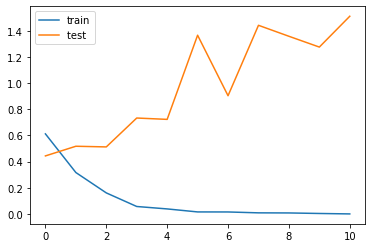

In [28]:
import matplotlib.pyplot as plt

plt.plot(history_Adam.history['loss'], label = "train")
plt.plot(history_Adam.history['val_loss'], label = "test ")



plt.legend()
plt.show()

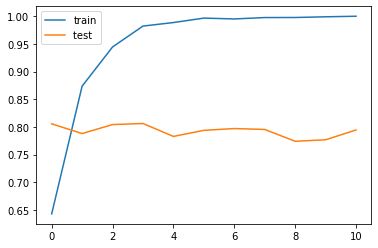

In [29]:
plt.plot(history_Adam.history['accuracy'], label = "train")
plt.plot(history_Adam.history['val_accuracy'], label = "test ")

plt.legend()
plt.show()


## Approach 5 - TwoLayer - GRU - with standarization
## https://www.dialog-21.ru/media/3380/arkhipenkoetal.pdf

In [42]:
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping
from keras.layers import Embedding, TextVectorization, Dense, LSTM, Input, Bidirectional, GRU

vectorize_layer = TextVectorization(
    max_tokens=50000,
    standardize="lower_and_strip_punctuation"
  )
vectorize_layer.adapt(X_train)

history_Adam = History()

model = Sequential()

# Vectorization
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

# Embedding
model.add(Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=64))


model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Bidirectional(GRU(64)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_17 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_17 (Embedding)    (None, None, 64)          3200000   
                                                                 
 bidirectional_28 (Bidirecti  (None, None, 256)        148992    
 onal)                                                           
                                                                 
 bidirectional_29 (Bidirecti  (None, 128)              123648    
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 32)                4128      
                                                     

In [43]:
model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=6, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, callbacks=[early_stopping, history_Adam])

Epoch 1/30
250/250 [==============================] - 74s 276ms/step - loss: 0.6401 - accuracy: 0.6174 - val_loss: 0.5772 - val_accuracy: 0.7452
Epoch 2/30
250/250 [==============================] - 69s 277ms/step - loss: 0.3661 - accuracy: 0.8436 - val_loss: 0.4651 - val_accuracy: 0.7954
Epoch 3/30
250/250 [==============================] - 68s 273ms/step - loss: 0.1511 - accuracy: 0.9448 - val_loss: 0.5512 - val_accuracy: 0.7921
Epoch 4/30
250/250 [==============================] - 69s 276ms/step - loss: 0.0533 - accuracy: 0.9841 - val_loss: 0.8045 - val_accuracy: 0.7878
Epoch 5/30
250/250 [==============================] - 69s 275ms/step - loss: 0.0276 - accuracy: 0.9927 - val_loss: 0.7982 - val_accuracy: 0.7858
Epoch 6/30
250/250 [==============================] - 68s 271ms/step - loss: 0.0231 - accuracy: 0.9927 - val_loss: 1.0235 - val_accuracy: 0.7887
Epoch 7/30
250/250 [==============================] - 67s 269ms/step - loss: 0.0176 - accuracy: 0.9954 - val_loss: 0.8765 - val_ac

In [44]:
model.evaluate(X_test,y_test)

1000/1000 [==============================] - 45s 45ms/step - loss: 0.9761 - accuracy: 0.7777


[0.9760738015174866, 0.7776874899864197]

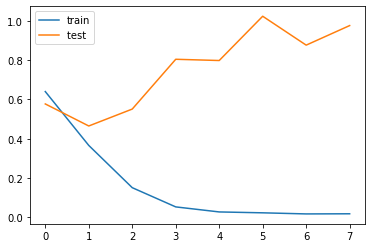

In [45]:
import matplotlib.pyplot as plt

plt.plot(history_Adam.history['loss'], label = "train")
plt.plot(history_Adam.history['val_loss'], label = "test ")



plt.legend()
plt.show()

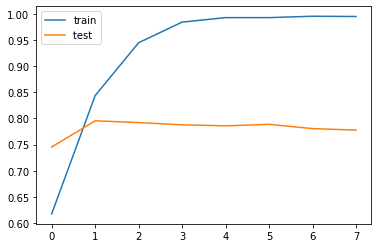

In [46]:
plt.plot(history_Adam.history['accuracy'], label = "train")
plt.plot(history_Adam.history['val_accuracy'], label = "test ")

plt.legend()
plt.show()


## Approach 6 - TwoLayer - GRU - with standarization and bigrams
## https://www.dialog-21.ru/media/3380/arkhipenkoetal.pdf

In [48]:
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping
from keras.layers import Embedding, TextVectorization, Dense, LSTM, Input, Bidirectional, GRU

vectorize_layer = TextVectorization(
    max_tokens=50000,
    standardize="lower_and_strip_punctuation",
    ngrams = 2
  )
vectorize_layer.adapt(X_train)

history_Adam = History()

model = Sequential()

# Vectorization
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

# Embedding
model.add(Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=64))


model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Bidirectional(GRU(64)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_18 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_18 (Embedding)    (None, None, 64)          3200000   
                                                                 
 bidirectional_30 (Bidirecti  (None, None, 256)        148992    
 onal)                                                           
                                                                 
 bidirectional_31 (Bidirecti  (None, 128)              123648    
 onal)                                                           
                                                                 
 dense_16 (Dense)            (None, 32)                4128      
                                                     

In [49]:
model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=6, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, callbacks=[early_stopping, history_Adam])

Epoch 1/30
250/250 [==============================] - 129s 496ms/step - loss: 0.6391 - accuracy: 0.6170 - val_loss: 0.7136 - val_accuracy: 0.4984
Epoch 2/30
250/250 [==============================] - 126s 504ms/step - loss: 0.5619 - accuracy: 0.7125 - val_loss: 0.4579 - val_accuracy: 0.7804
Epoch 3/30
250/250 [==============================] - 125s 503ms/step - loss: 0.2235 - accuracy: 0.9143 - val_loss: 0.3621 - val_accuracy: 0.8462
Epoch 4/30
250/250 [==============================] - 127s 510ms/step - loss: 0.0389 - accuracy: 0.9896 - val_loss: 0.4243 - val_accuracy: 0.8453
Epoch 5/30
250/250 [==============================] - 127s 509ms/step - loss: 0.0207 - accuracy: 0.9949 - val_loss: 0.5747 - val_accuracy: 0.8430
Epoch 6/30
250/250 [==============================] - 124s 499ms/step - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.7612 - val_accuracy: 0.8332
Epoch 7/30
250/250 [==============================] - 124s 498ms/step - loss: 0.0016 - accuracy: 0.9999 - val_loss: 0.8085 -

In [50]:
model.evaluate(X_test,y_test)

1000/1000 [==============================] - 83s 83ms/step - loss: 0.9474 - accuracy: 0.8388


[0.9474169015884399, 0.8387812376022339]

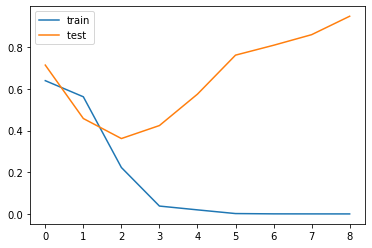

In [51]:
import matplotlib.pyplot as plt

plt.plot(history_Adam.history['loss'], label = "train")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

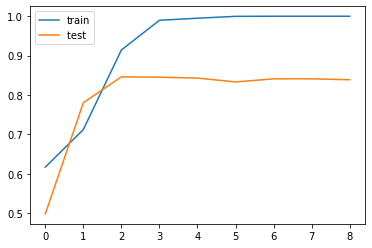

In [52]:
plt.plot(history_Adam.history['accuracy'], label = "train")
plt.plot(history_Adam.history['val_accuracy'], label = "test ")

plt.legend()
plt.show()
